In [1]:
!pip install clarabel proxsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/shaoanlu/pyMPC_Clarabel.git

Cloning into 'pyMPC_Clarabel'...
remote: Enumerating objects: 856, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 856 (delta 60), reused 69 (delta 31), pack-reused 744 (from 1)
Receiving objects: 100% (856/856), 2.47 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (492/492), done.


In [1]:
%cd pyMPC_Clarabel

/content/pyMPC_Clarabel


In [2]:
!pip install -e .

Obtaining file:///content/pyMPC_Clarabel
  Preparing metadata (setup.py) ... done
  Attempting uninstall: python-mpc
    Found existing installation: python-mpc 0.1.1
    Uninstalling python-mpc-0.1.1:
      Successfully uninstalled python-mpc-0.1.1
  Running setup.py develop for python-mpc


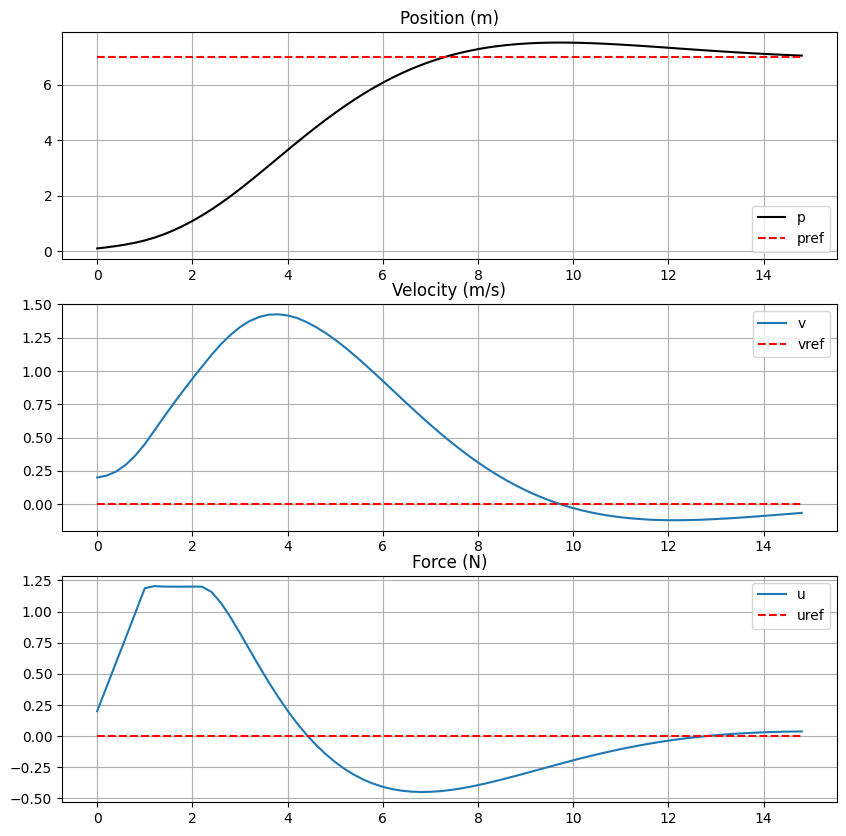

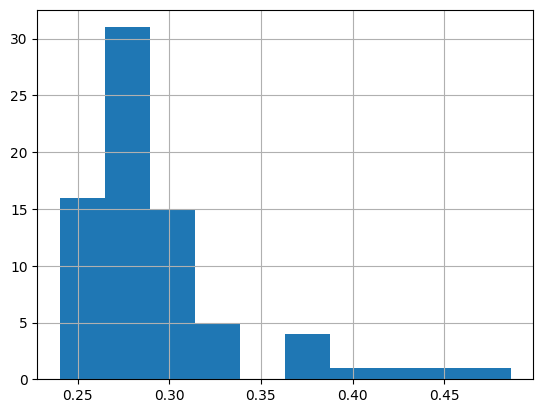

In [6]:
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
from pyMPC.mpc import MPCController
from scipy.integrate import ode


# Constants #
Ts = 0.2 # sampling time (s)
M = 2    # mass (Kg)
b = 0.3  # friction coefficient (N*s/m)

# Continuous-time matrices (just for reference)
Ac = np.array([
    [0.0, 1.0],
    [0, -b/M]]
)
Bc = np.array([
    [0.0],
    [1/M]
])

def f_ODE(t,x,u):
    der = Ac @ x + Bc @ u
    return der

[nx, nu] = Bc.shape  # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts


# Reference input and states
pref = 7.0
vref = 0.0
xref = np.array([pref, vref]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100.0])
xmax = np.array([100.0,   100.0])

umin = np.array([-1.2])
umax = np.array([1.2])

Dumin = np.array([-2e-1])
Dumax = np.array([2e-1])

# Objective function
Qx = sparse.diags([0.5, 0.1])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.5, 0.1])  # Quadratic cost for xN
Qu = 2.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 10.0 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initial state
x0 = np.array([0.1, 0.2]) # initial state
system_dyn = ode(f_ODE).set_integrator('vode', method='bdf')
system_dyn.set_initial_value(x0, 0)
system_dyn.set_f_params(0.0)

# Prediction horizon
Np = 20

K = MPCController(
    Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
    Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
    xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax,
    qp_backend="osqp"
)
K.setup()

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 15 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tcalc = np.zeros((nsim,1))
tsim = np.arange(0,nsim)*Ts



xstep = x0
uMPC = uminus1

time_start = time.time()
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    time_start = time.time()
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    tcalc[i,:] = time.time() - time_start
    usim[i,:] = uMPC

    #xstep = Ad.dot(xstep) + Bd.dot(uMPC)  # Real system step (x_k+1 value)
    system_dyn.set_f_params(uMPC) # set current input value to uMPC
    system_dyn.integrate(system_dyn.t + Ts)
    xstep = system_dyn.y


time_sim = time.time() - time_start
fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="pref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,1], label="v")
axes[1].plot(tsim, xref[1]*np.ones(np.shape(tsim)), "r--", label="vref")
axes[1].set_title("Velocity (m/s)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="uref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.figure()
plt.hist(tcalc*1000)
plt.grid(True)

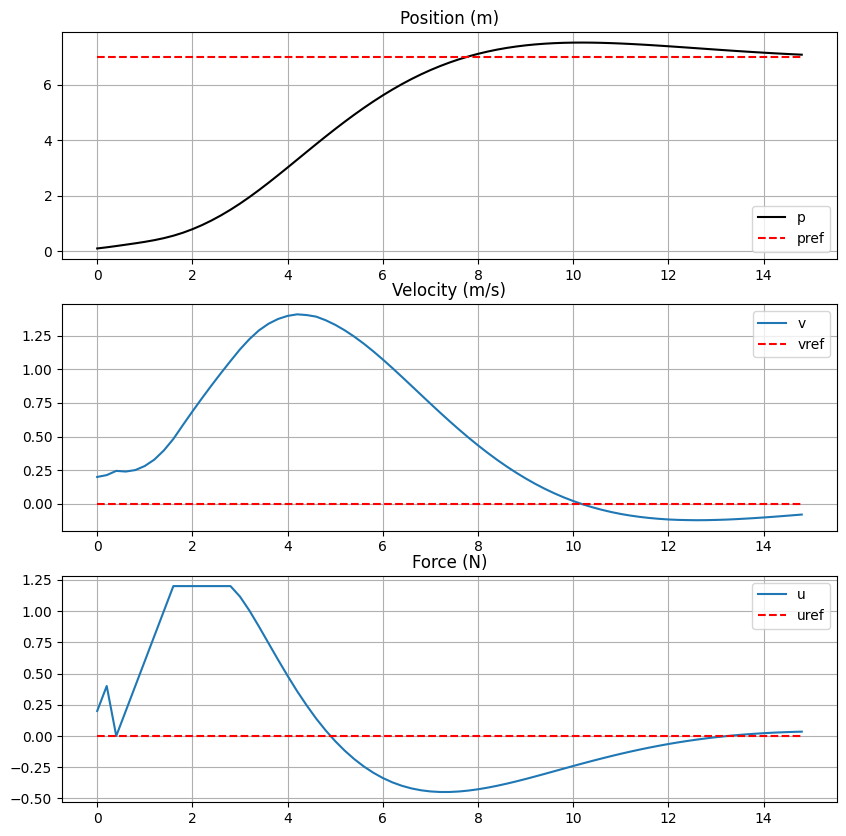

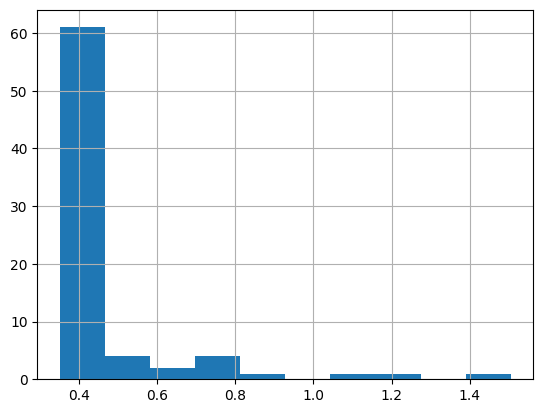

In [7]:
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
from pyMPC.mpc import MPCController
from scipy.integrate import ode


# Constants #
Ts = 0.2 # sampling time (s)
M = 2    # mass (Kg)
b = 0.3  # friction coefficient (N*s/m)

# Continuous-time matrices (just for reference)
Ac = np.array([
    [0.0, 1.0],
    [0, -b/M]]
)
Bc = np.array([
    [0.0],
    [1/M]
])

def f_ODE(t,x,u):
    der = Ac @ x + Bc @ u
    return der

[nx, nu] = Bc.shape  # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts


# Reference input and states
pref = 7.0
vref = 0.0
xref = np.array([pref, vref]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100.0])
xmax = np.array([100.0,   100.0])

umin = np.array([-1.2])
umax = np.array([1.2])

Dumin = np.array([-2e-1])
Dumax = np.array([2e-1])

# Objective function
Qx = sparse.diags([0.5, 0.1])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.5, 0.1])  # Quadratic cost for xN
Qu = 2.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 10.0 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initial state
x0 = np.array([0.1, 0.2]) # initial state
system_dyn = ode(f_ODE).set_integrator('vode', method='bdf')
system_dyn.set_initial_value(x0, 0)
system_dyn.set_f_params(0.0)

# Prediction horizon
Np = 20

K = MPCController(
    Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
    Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
    xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax,
    qp_backend="proxqp"
)
K.setup()

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 15 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tcalc = np.zeros((nsim,1))
tsim = np.arange(0,nsim)*Ts



xstep = x0
uMPC = uminus1

time_start = time.time()
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    time_start = time.time()
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    tcalc[i,:] = time.time() - time_start
    usim[i,:] = uMPC

    #xstep = Ad.dot(xstep) + Bd.dot(uMPC)  # Real system step (x_k+1 value)
    system_dyn.set_f_params(uMPC) # set current input value to uMPC
    system_dyn.integrate(system_dyn.t + Ts)
    xstep = system_dyn.y


time_sim = time.time() - time_start
fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="pref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,1], label="v")
axes[1].plot(tsim, xref[1]*np.ones(np.shape(tsim)), "r--", label="vref")
axes[1].set_title("Velocity (m/s)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="uref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.figure()
plt.hist(tcalc*1000)
plt.grid(True)

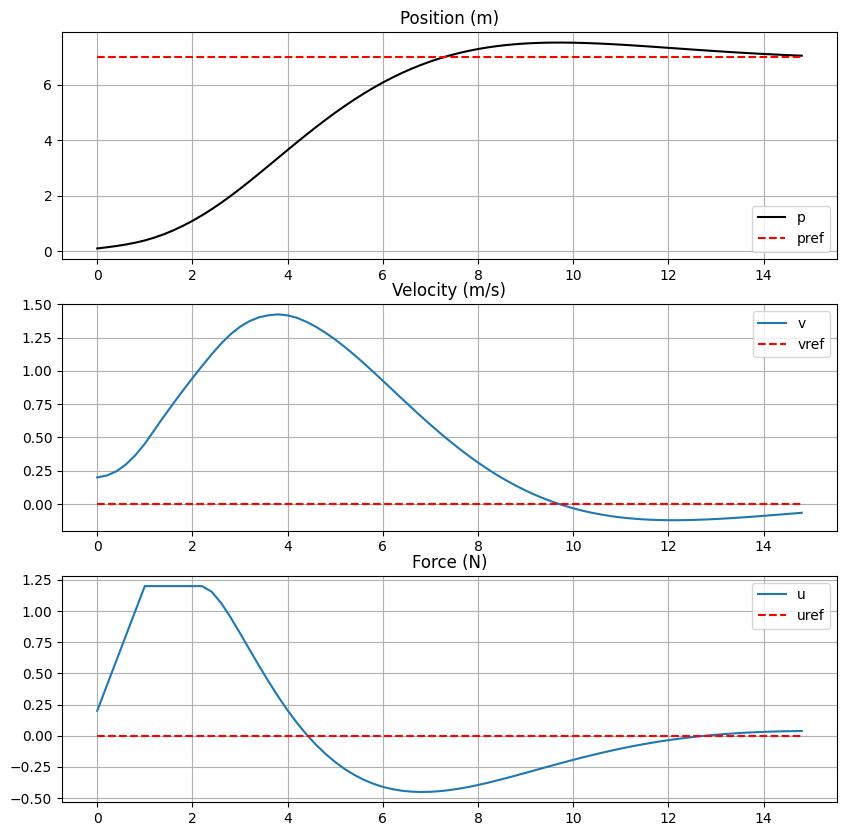

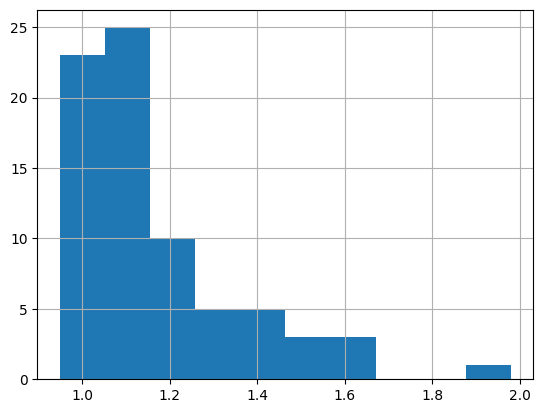

In [8]:
import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
from pyMPC.mpc import MPCController
from scipy.integrate import ode


# Constants #
Ts = 0.2 # sampling time (s)
M = 2    # mass (Kg)
b = 0.3  # friction coefficient (N*s/m)

# Continuous-time matrices (just for reference)
Ac = np.array([
    [0.0, 1.0],
    [0, -b/M]]
)
Bc = np.array([
    [0.0],
    [1/M]
])

def f_ODE(t,x,u):
    der = Ac @ x + Bc @ u
    return der

[nx, nu] = Bc.shape  # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts


# Reference input and states
pref = 7.0
vref = 0.0
xref = np.array([pref, vref]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100.0])
xmax = np.array([100.0,   100.0])

umin = np.array([-1.2])
umax = np.array([1.2])

Dumin = np.array([-2e-1])
Dumax = np.array([2e-1])

# Objective function
Qx = sparse.diags([0.5, 0.1])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.5, 0.1])  # Quadratic cost for xN
Qu = 2.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 10.0 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initial state
x0 = np.array([0.1, 0.2]) # initial state
system_dyn = ode(f_ODE).set_integrator('vode', method='bdf')
system_dyn.set_initial_value(x0, 0)
system_dyn.set_f_params(0.0)

# Prediction horizon
Np = 20

K = MPCController(
    Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
    Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
    xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax,
    qp_backend="clarabel"
)
K.setup()

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 15 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tcalc = np.zeros((nsim,1))
tsim = np.arange(0,nsim)*Ts



xstep = x0
uMPC = uminus1

time_start = time.time()
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    time_start = time.time()
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    tcalc[i,:] = time.time() - time_start
    usim[i,:] = uMPC

    #xstep = Ad.dot(xstep) + Bd.dot(uMPC)  # Real system step (x_k+1 value)
    system_dyn.set_f_params(uMPC) # set current input value to uMPC
    system_dyn.integrate(system_dyn.t + Ts)
    xstep = system_dyn.y


time_sim = time.time() - time_start
fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="pref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,1], label="v")
axes[1].plot(tsim, xref[1]*np.ones(np.shape(tsim)), "r--", label="vref")
axes[1].set_title("Velocity (m/s)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="uref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.figure()
plt.hist(tcalc*1000)
plt.grid(True)